In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)

# Nazwa zbioru danych


In [2]:
dataset = os.path.basename(os.getcwd())

# Importy


In [14]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)

# Import danych


In [4]:
# open zip in raw/data.zip and extract file to this folder
import zipfile
with zipfile.ZipFile(f'../../data/raw/{dataset}.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data/raw')

In [5]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), f"../../data/raw/{dataset}.csv"))
raw_data.head()

,text,rating
0,We went here with our kids for Xmas holiday an...,4
1,We have spent in this hotel our summer holiday...,4
2,I visited Hotel Baltic with my husband for som...,4
3,I've travelled quite a numbers of hotels but t...,4
4,We decided for this family holiday destination...,3


# Analiza danych

In [6]:
print(f"shape: {raw_data.shape}")
raw_data.info()

shape: (1000000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1000000 non-null  object
 1   rating  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


Mamy do czynienia ze zbiorem 1 miliona rekordów, rekordy składają się z opinii tekstowej oraz oceny dyskretnej w skali 0-4. Każda z klas oceny oznacza liczbę gwiazdek którą otrzymał hotel. Wliczenie liczby gwiazdek połączonej do danej opinii tekstowej liczymy ze wzoru wartość + 1. Czyli na przykład opinia o klasie z wartością 4 oznacza opinię pięciogwiazdkową.

In [7]:
# show how many duplicates there are

duplicates = raw_data.duplicated().sum()
print(f"duplicates: {duplicates}")

# show how many times each dupicate is repeated
duplicates = raw_data[raw_data.duplicated(keep=False)].sort_values(by=list(raw_data.columns))
duplicates['count'] = 1
duplicates = duplicates.groupby(list(raw_data.columns)).count()
duplicates = duplicates[duplicates['count'] > 1]
duplicates.sort_values(by='count', ascending=False)



duplicates: 38


,,count
text,rating,
"Absolutely fabulous place. Great service, perfect suite very up to date with exceptional disabled room facilities. Me being in wheelchair have found it hard travelling Europe to find great services for my disability. I need a roll in shower and spacious areas. This apartment is absolutely perfect. HUGE shower. The only down side was that my bed was quite low in terms of transferring to my chairs, however staff were brilliant in making the bed higher to suit me. Other than that, fast prompt service with food or whatever you need. So friendly and inviting, had a lovely stay. Highly recommended!!",4,2
We found this hotel to be great value for money. Was in a great location - close to the metro but only 15 mins walk from the city centre - Notre Dame. Room was big enough for the two of us and we had a nice window that opened out onto the street. Room was very quiet once the window was closed. Staff very friendly and helpful. Fast food outlets just round the corner. Would reccommend this hotel,3,2
"The hotel was very comfortable, clean, friendly, good breakfast, great games room. overall we had a great stay. It's a bit far from the mountain for my liking ( about 20 min to Burke- closest ski hill) Also, pool was too warm for my liking and their hot tub too cold, sauna should have been also warmer, but we couldn't figure out way to make it warmer. They also have liitle gym which is nice.",4,2
"This hotel did not knock my socks off - not by any stretch of the imagination. The rooms were fine nothing to complain of - clean, neat and comfortable. The suite which i was upgraded to was sufficiently spacious. I have stayed in other Hilton Garden Inn's with much nicer rooms/suites, but the standard of comfort remains a priority even at this hotel. The service was good - upon request I was upgraded to a suite, but only because one member of the reception team was far more willing to be helpful than the other. So one staff member counterbalancing the other. Neither were unpleasant. The breakfast was good and the service as is to be expected from HGI. Ultimately, the value received is very high given the proximity to entertainment /airport/ shopping within a 15 min drive.",3,2
"This was my husband and my first week at our Timeshare in the four Seasons at Quinta and we thoroughly enjoyed our time there. The villa is equipped to such a high standard and i very, very comfortable. The whole resort is of as equally high a standard and the resort staff very helpful and friendly. We can't wait to come back again next year.",4,2
"This was our second time back to this hotel and once again we really enjoyed our stay. The front desk gentlemen brought our baby bed as soon as we requested it. The breakfast restaurant menu had good choices to choose from, all included in your room price except for the tip for the servers. The front door wait can be a little long though to be seated. The cleanliness and comfort of the beds and room were awesome. The only complaint I had was that we asked for extra towels and got them about 6 hours later once we had gotten back to our room and had already forgotten about them, with someone just knocking randomly on the door and saying sorry about the delay. We also asked for decaf coffee for the room which most hotels supply both regular and decaf in the room, and just never received it at all. Otherwise great place to stay!",4,2
"Upon arrival to our destination we instantly felt we had entered paradise! Villa Amor is spectacular! Beautiful. Manicured. Spacious. Unique! The staff was meticulous & courteous. The grounds blew us away! Imagine living INSIDE exquisite nature. We took our 4yo son with us who had the time of his life. The hammocks under the banana trees at V.A. were unforgettable, RELAXING moments with him. He LOVED waking up with the sun & venturing to they amazing beach right in front of us! We considered staying outside of town in a small exclusive hotel nearby but we're so happy we chose V.

In [8]:
raw_data.duplicated().sum()

38

Mamy 38 rekordów zduplokowanych. Nie jest to dużo, ususniemy je.

In [9]:
#delete duplicated records
raw_data.drop_duplicates(inplace=True)

## Dysproporcje w klasach

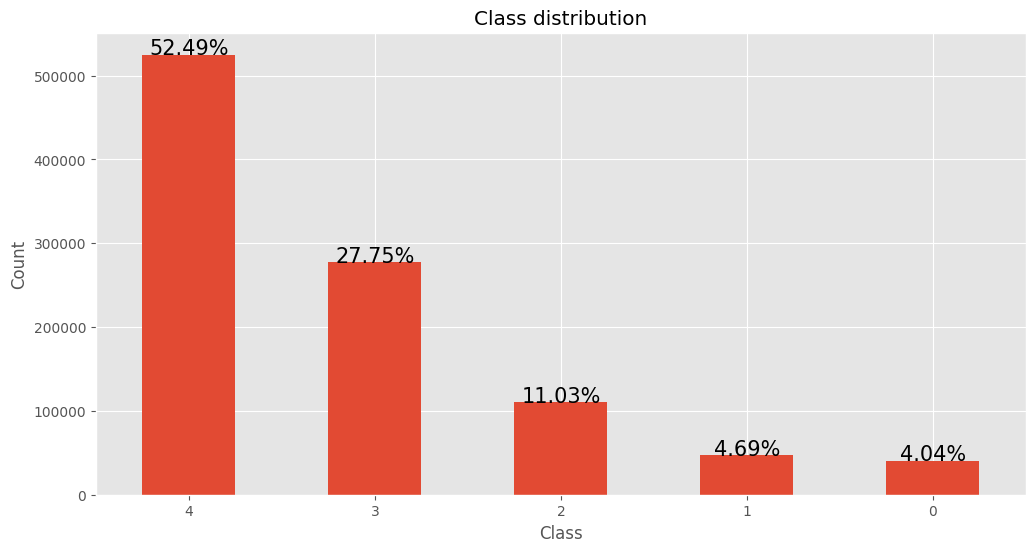

In [15]:
# Plot the distribution of the class attribute
raw_data['rating'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count', rot=0)

## add a procentage value that shows on the top of each bar
for i in range(5):
    plt.text(i, raw_data['rating'].value_counts()[4-i], f"{round(raw_data['rating'].value_counts(normalize=True)[4-i]*100, 2)}%", ha='center', size=15)



In [11]:
## save the dataset
raw_data.to_csv(f"{dataset}_processed_1M.csv", index=False)

# Wnioski z analizy danych
W zbiorze występują znaczne dysproporcje w kontekście dystrybucji atrybutu klasy. Klasa większościową, którą jest klasa reprezentująca opinię pięciogwiazdkową stanowi ponad 50\% całego zbioru. Jest to zarazem plus jak i minus. Z uwagi na tą dysproporcję sensownym pomysłem będzie jako base-line projektu przyjąć model, który jako predykcję za każdym razem zwraca klasę większościową. Możemy się spodziewać, że statystycznie taki model będzie posiadał celność około 52.49\% dla zbioru testowego. Dla modeli bardziej skomplikowanych, takich jak transformer RoBERTa, skutki tej dysproporcji muszą zostać zniwelowane poprzez zastosowanie warzenia klas w trakcie nauki. Wprowadzenie tego mechanizmu powinny zmniejszyć przeuczanie się modelu.

## Zbiór zbalansowany

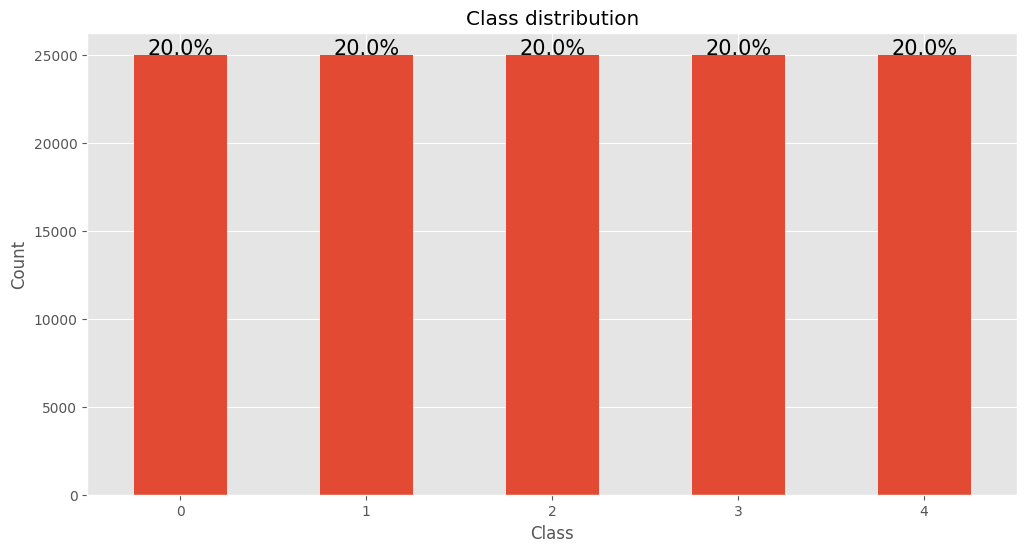

In [16]:
# make a new dataset that contains 25k records of each class

# get 25k records of each class
data = raw_data.groupby('rating').apply(lambda x: x.sample(25000)).reset_index(drop=True)

# plot the distribution of the class attribute

data['rating'].value_counts().plot(kind='bar', title='Class distribution', xlabel='Class', ylabel='Count', rot=0)

## add a procentage value that shows on the top of each bar

for i in range(5):
    plt.text(i, data['rating'].value_counts()[4-i], f"{round(data['rating'].value_counts(normalize=True)[4-i]*100, 2)}%", ha='center', size=15)

## save the dataset

data.to_csv(f"../../data/processed/{dataset}_processed_balanced_125k.csv", index=False)